<a href="https://colab.research.google.com/github/hiwasaki1712/python_notebooks/blob/main/compare_np_slice_vs_list_insert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1d配列の順位の入替操作での、速さ比較

問題設定: ある順位rankの値をrank-diff位に移動する。

- np.ndarrayのslice
- np.ndarrayのinsertとdelete
- listのpopとinsert

結果サマリ
- n $\lesssim$ 1e3 ならリストが高速
- n $\gtrsim$ 1e3 で、移動範囲が diff << n ならnumpyのスライスが有利
- n $\gtrsim$ 1e3 で、移動範囲が diff $\simeq$ n ならnumpyもリストも時間に差は出ない。uint32のNumpy ndarrayの方がメモリ面で有利。
- Numpyを使うなら速度面でスライス一択。insertやrollは遅くなる。

※ 演算時の消費メモリや内部処理の詳細は見ていない。

In [16]:
import numpy as np
import sys
import time
import gc
import matplotlib.pyplot as plt

## 関数定義

速度計測するだけなので、順位UPのみ実装

In [17]:
def slice_up(arr, rank, diff):
    v_rank = arr[rank]
    arr[rank-diff+1:rank+1] = arr[rank-diff:rank]
    arr[rank-diff] = v_rank
    return arr

def roll_up(arr, rank, diff):
    arr[rank-diff:rank+1] = np.roll(arr[rank-diff:rank+1], 1)
    return arr


def ins_up(arr, rank, diff):
    arr = np.insert(arr, rank-diff, arr[rank])
    arr = np.delete(arr, rank+1)
    return arr

def list_up(arr, rank, diff):
    v_rank = arr.pop(rank)
    arr.insert(rank-diff, v_rank)
    return arr

### 関数の実行確認

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] の5位を2個順位を上げる。
つまり、5位の値を5-2=3位に移動させて、
[0, 1, 2, 5, 3, 4, 6, 7, 8, 9] にする。

In [18]:
n = 10

In [19]:
arr = np.arange(n)
slice_up(arr, 5, 2)

array([0, 1, 2, 5, 3, 4, 6, 7, 8, 9])

In [20]:
arr = np.arange(n)
roll_up(arr, 5, 2)

array([0, 1, 2, 5, 3, 4, 6, 7, 8, 9])

In [21]:
arr = np.arange(n)
ins_up(arr, 5, 2)

array([0, 1, 2, 5, 3, 4, 6, 7, 8, 9])

In [22]:
ll = list(range(n))
list_up(ll, 5, 2)

[0, 1, 2, 5, 3, 4, 6, 7, 8, 9]

## 配列の生成時間と生成オブジェクトのメモリサイズ

In [23]:
### 100回ずつ試行し、実行時間の平均を計測

trial_n = 100
n_list = [10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 10000, 20000, 40000, 50000, 70000, 90000, 100000]

time_arange_ui32 = []
time_arange_i32 = []
time_arange_ui64 = []
time_arange_i64 = []
time_array = []
time_listgen = []
size_i32 = []
size_i64 = []
size_ui32 = []
size_ui64 = []
size_list = []
size_array = []

gc.collect()

for n in n_list:
    cnt = 0
    _time_arange_i32 = []
    _time_arange_i64 = []
    _time_arange_ui32 = []
    _time_arange_ui64 = []
    _time_array = []
    _time_listgen = []
    _size_i32 = []
    _size_i64 = []
    _size_ui32 = []
    _size_ui64 = []
    _size_list = []
    _size_array = []
    while cnt < trial_n:

        ### int32 np.arange の生成時間、消費メモリを計測
        t0 = time.time()
        arr = np.arange(n, dtype=np.int32)
        t1 = time.time()
        _time_arange_i32.append(t1-t0)
        _size_i32.append(sys.getsizeof(arr))

        ### int64 np.arange の生成時間、消費メモリを計測
        t0 = time.time()
        arr = np.arange(n, dtype=np.int64)
        t1 = time.time()
        _time_arange_i64.append(t1-t0)
        _size_i64.append(sys.getsizeof(arr))

        ### uint32 np.arange の生成時間、消費メモリを計測
        t0 = time.time()
        arr = np.arange(n, dtype=np.uint32)
        t1 = time.time()
        _time_arange_ui32.append(t1-t0)
        _size_ui32.append(sys.getsizeof(arr))

        ### uint64 np.arange の生成時間、消費メモリを計測
        t0 = time.time()
        arr = np.arange(n, dtype=np.uint64)
        t1 = time.time()
        _time_arange_ui64.append(t1-t0)
        _size_ui64.append(sys.getsizeof(arr))

        ### list の生成時間、消費メモリを計測
        t0 = time.time()
        ll = list(range(n))
        t1 = time.time()
        _time_listgen.append(t1-t0)
        _size_list.append(sys.getsizeof(ll))

        ### list からのnp.ndarrayの生成時間、消費メモリを計測
        t0 = time.time()
        arr = np.array(ll)
        t1 = time.time()
        _time_array.append(t1-t0)
        _size_array.append(sys.getsizeof(arr))

        cnt += 1

    ### elapesed time (ms)
    time_arange_i32.append(np.median(_time_arange_i32) * 1e6)
    time_arange_i64.append(np.median(_time_arange_i64) * 1e6)
    time_arange_ui32.append(np.median(_time_arange_ui32) * 1e6)
    time_arange_ui64.append(np.median(_time_arange_ui64) * 1e6)
    time_array.append(np.median(_time_array) * 1e6)
    time_listgen.append(np.median(_time_listgen) * 1e6)

    size_i32.append(np.median(_size_i32))
    size_i64.append(np.median(_size_i64))
    size_ui32.append(np.median(_size_ui32))
    size_ui64.append(np.median(_size_ui64))
    size_list.append(np.median(_size_list))
    size_array.append(np.median(_size_array))

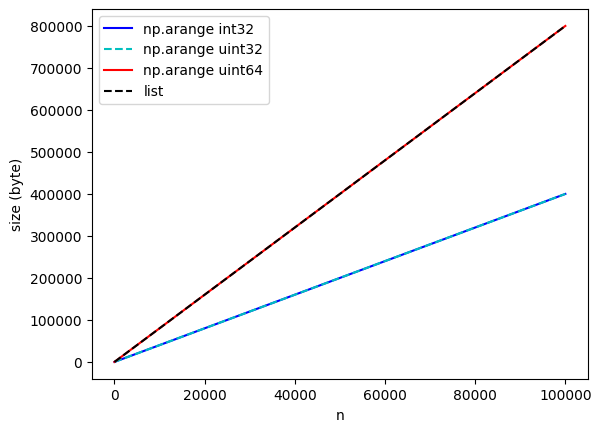

In [24]:
### メモリサイズをプロット
plt.plot(n_list, size_i32, 'b-', label='np.arange int32')
plt.plot(n_list, size_ui32, 'c--', label='np.arange uint32')
# plt.plot(n_list, size_i64, '-', label='np.arange int64')
plt.plot(n_list, size_ui64, 'r-', label='np.arange uint64')
plt.plot(n_list, size_list, 'k--', label='list')
# plt.plot(n_list, size_array, 'c:', label='np.array')
plt.legend()
plt.xlabel('n')
plt.ylabel('size (byte)')
plt.show()

- listは 64bit
- 32bit np.ndarray は当然メモリ半分

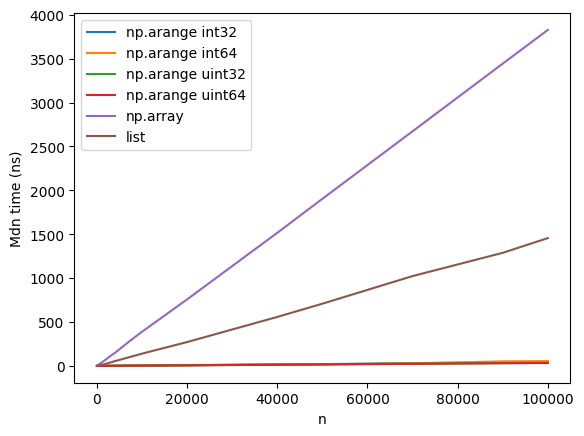

In [25]:
### 生成時間をプロット(線形スケール)
plt.plot(n_list, time_arange_i32, label='np.arange int32')
plt.plot(n_list, time_arange_i64, label='np.arange int64')
plt.plot(n_list, time_arange_ui32, label='np.arange uint32')
plt.plot(n_list, time_arange_ui64, label='np.arange uint64')
plt.plot(n_list, time_array, label='np.array')
plt.plot(n_list, time_listgen, label='list')
plt.xlabel('n')
plt.ylabel('Mdn time (ns)')
plt.legend()
plt.show()

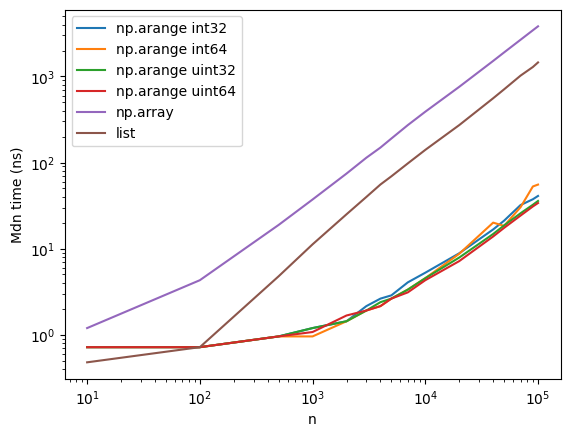

In [26]:
### 生成時間をプロット(対数スケール)
plt.plot(n_list, time_arange_i32, label='np.arange int32')
plt.plot(n_list, time_arange_i64, label='np.arange int64')
plt.plot(n_list, time_arange_ui32, label='np.arange uint32')
plt.plot(n_list, time_arange_ui64, label='np.arange uint64')
plt.plot(n_list, time_array, label='np.array')
plt.plot(n_list, time_listgen, label='list')
plt.xlabel('n')
plt.ylabel('Mdn time (ns)')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

観察
- どれも、要素数nに対し線形的に時間増加
- np.arange は、型に依らず、listより速い
- listは n > 1e2 でnp.arangeより遅い
- listをnp.arrayにするのは時間かかる

結論
- たいていの場合np.arangeが最速。32bitならリストより省メモリ
- listが渡されるならそのまま使うのが速いこともある。

## 各関数の実行時間を確認。順位移動量は固定

In [27]:
### 100回ずつ試行し、実行時間の平均を計測

trial_n = 100
dtype = np.uint32
rank = 90
diff = 80
n_list = [100, 500, 1000, 2000, 3000, 4000, 5000, 10000, 50000, 100000]

def measure(func, arr, rank, diff):
    t0 = time.time()
    func(arr, rank, diff)
    t1 = time.time()
    return t1-t0


time_slice = []
time_roll = []
time_ins = []
time_list = []
time_arange = []
time_array = []
time_listgen = []

gc.collect()


for n in n_list:
    cnt = 0
    _time_slice = []
    _time_roll = []
    _time_ins = []
    _time_list = []
    _time_arange = []
    _time_array = []
    _time_listgen = []
    while cnt < trial_n:

        ### np.arangeでのarray生成と時間計測
        t0 = time.time()
        arr = np.arange(n, dtype=dtype)
        t1 = time.time()
        _time_arange.append(t1-t0)

        ### Numpyのsliceでの順位操作の実行時間計測
        delta = measure(slice_up, arr, rank, diff)
        _time_slice.append(delta)

        ### Numpyのinsertとdeleteでの順位操作の実行時間計測
        delta = measure(ins_up, arr, rank, diff)
        _time_ins.append(delta)

        ### Numpyのroll関数での順位操作の実行時間計測
        delta = measure(roll_up, arr, rank, diff)
        _time_roll.append(delta)

        ### list生成と時間計測
        t0 = time.time()
        ll = list(range(n))
        t1 = time.time()
        _time_listgen.append(t1-t0)

        ### listのpopとinsertでの順位操作の実行時間計測
        delta = measure(list_up, ll, rank, diff)
        _time_list.append(delta)

        ### listからのnp.array実行時間計測
        t0 = time.time()
        arr = np.array(ll, dtype=dtype)
        t1 = time.time()
        _time_array.append(t1-t0)

        cnt += 1

    ### elapesed time (ms)
    time_slice.append(np.mean(_time_slice) * 1e6)
    time_roll.append(np.mean(_time_roll) * 1e6)
    time_ins.append(np.mean(_time_ins) * 1e6)
    time_list.append(np.mean(_time_list) * 1e6)
    time_arange.append(np.mean(_time_arange) * 1e6)
    time_array.append(np.mean(_time_array) * 1e6)
    time_listgen.append(np.mean(_time_listgen) * 1e6)

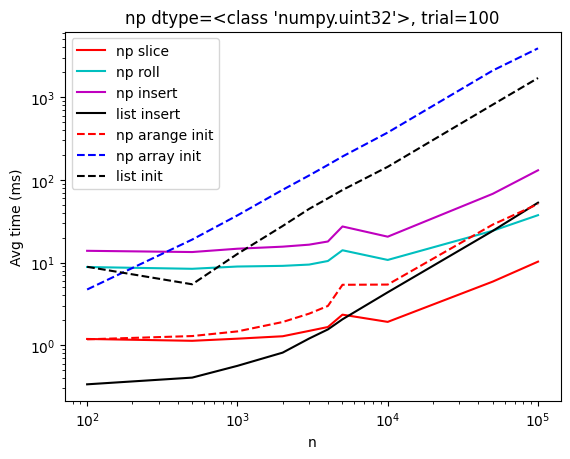

In [28]:
plt.title(f'np dtype={dtype}, trial={trial_n}')
plt.plot(n_list, time_slice, 'r-', label='np slice')
plt.plot(n_list, time_roll, 'c-', label='np roll')
plt.plot(n_list, time_ins, 'm-', label='np insert')
plt.plot(n_list, time_list, 'k-', label='list insert')
plt.plot(n_list, time_arange, 'r--', label='np arange init')
plt.plot(n_list, time_array, 'b--', label='np array init')
plt.plot(n_list, time_listgen, 'k--', label='list init')
plt.xlabel('n')
plt.ylabel('Avg time (ms)')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

実線は順位操作の実行時間、破線は配列生成にかかる時間

観察
- 配列生成時間 np.arange < list < np.array  
0,1,2,...の配列ならnp.arangeで作る。リストが与えられるならリストのままが速い
- list insert vs np slice  
n < 1e3 程度ではlistが速く、n > 1e4 程度ではNumpyが速い。
listの方が要素数による処理時間の変化が大きく、Numpyは変化幅小さい。
- Numpyでの処理時間 slice < np.roll < np.insert  
np.ndarrayならスライス一択



## 移動の範囲を変えて実験

diff_listで順位変動の範囲を変えて、npとlistでの処理時間の傾向を調べる

In [29]:
### 100回ずつ試行し、実行時間の平均を計測

trial_n = 100
dtype = np.uint32
diff_list = [5, 500, 5000, 50000]
n_list = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 5000, 6000, 10000, 50000, 60000, 100000]

def measure(func, arr, rank, diff):
    """ 配列arrのrank位の値をrank-diff位へ移動する関数funcの実行時間を計測 """
    t0 = time.time()
    func(arr, rank, diff)
    t1 = time.time()
    return t1-t0

def measure_trial(func, arr, rank, diff, trial_n):
    """ trial_n回、measureを実行 """
    t_list = []
    for _ in range(trial_n):
        delta = measure(func, arr, rank, diff)
        t_list.append(delta)
    return t_list

def gen_arr(n, dtype, is_np=True):
    """ 配列を生成 """
    if is_np:
        t0 = time.time()
        arr = np.arange(n, dtype=dtype)
        t1 = time.time()
    else:
        t0 = time.time()
        arr = list(range(n))
        t1 = time.time()
    return arr, t1-t0

def measure_scan_n(func, diff, n_list, trial_n, is_np=True):
    """ 配列の要素数をn_list内のnとして、実行時間を計測 """
    rank = diff + 1
    mdn_t_list = []
    qnt_t_list = []
    used_n_list = []
    for n in n_list:
        if n <= diff:
            continue
        else:
            ### 配列生成
            arr, _ = gen_arr(n, dtype, is_np)
            ### trial_n 回実行して時間計測
            t_list = measure_trial(func, arr, rank, diff, trial_n)
            ### median を計算 (ms)
            mdn_t_list.append(np.median(t_list) * 1e6)
            ### quantile を計算 (ms)
            qnt_t_list.append(np.quantile(t_list, [0.25, 0.75]) * 1e6)
            used_n_list.append(n)
    return mdn_t_list, used_n_list, qnt_t_list

time_slice = []
time_roll = []
time_ins = []
time_list = []
time_arange = []
time_array = []
time_listgen = []

gc.collect()

### 順位変動の幅を変えて、計測を実施
for diff in diff_list:
    _time_slice = measure_scan_n(slice_up, diff, n_list, trial_n)
    time_slice.append(_time_slice)

    _time_list = measure_scan_n(list_up, diff, n_list, trial_n, is_np=False)
    time_list.append(_time_list)


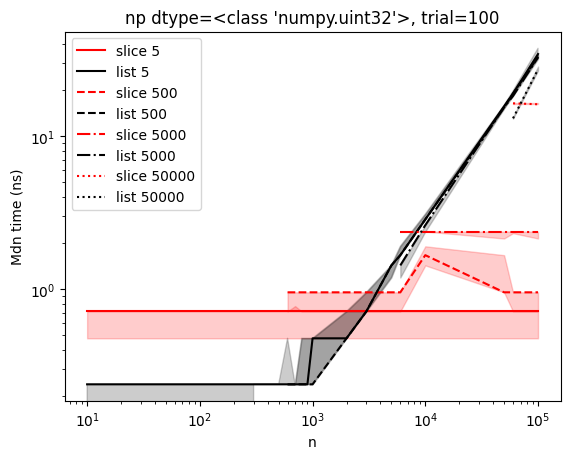

In [30]:
### 処理時間をプロット
line_styles = ['-', '--', '-.', ':'] * 2

for i, diff in enumerate(diff_list):

    ### Numpyのsliceの結果
    x = time_slice[i][1]
    y = np.array(time_slice[i][0])
    y_q = np.array(time_slice[i][2])

    plt.fill_between(x, y_q[:, 0], y_q[:, 1], color='r', alpha=0.2)
    plt.plot(x, y, color='r', ls=line_styles[i], label=f'slice {diff}')

    ### listのpopとinsertの結果
    x_ll = time_list[i][1]
    y_ll = np.array(time_list[i][0])
    y_q_ll = np.array(time_list[i][2])

    plt.fill_between(x_ll, y_q_ll[:, 0], y_q_ll[:, 1], color='k', alpha=0.2)
    plt.plot(x_ll, y_ll, color='k', ls=line_styles[i], label=f'list {diff}')

plt.title(f'np dtype={dtype}, trial={trial_n}')
plt.xlabel('n')
plt.ylabel('Mdn time (ns)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

プロットはmedianの線に、四分位範囲を表示した。

観察
- listの速度は順位の移動範囲に依らない。要素数nが増えると線形的に時間がかかる
- npのスライスは移動範囲が同じなら、nに依らずほぼ一定の速度。移動範囲が増えると線形で時間がかかる。

結論
- n < 1e3 ならリストが有利
- n > 1e3 で、移動範囲が diff << n ならnumpyのスライスが有利
- n > 1e3 で、移動範囲が diff ~ n ならnumpyもリストも時間に差は出ない
